In [ ]:
# CELL-01
#####################################
## import all required libraries, and perform some basic parameter setup
#####################################
import csv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from random import randint
import numpy as np
import itertools

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, AveragePooling2D, Conv2D, Cropping2D, Dropout, MaxPooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger
from keras.utils.visualize_util import plot

# some Jupyter initilizations
# Visualizations will be shown in the notebook.
%matplotlib inline
img_base_dir = ''

# Specifics to the NVidia Model
model_image_height = 33 + 95 #(cropped out in the model itself)
model_image_width = 100

# Some definitions
datasets = [
  '/home/bcornelis/UdacitySelfDrivingCar/CarND-Behavioral-Cloning-P3-2/data/',
  '/home/bcornelis/UdacitySelfDrivingCar/CarND-Behavioral-Cloning-P3/datasets/3lapsnormal/',
  '/home/bcornelis/UdacitySelfDrivingCar/CarND-Behavioral-Cloning-P3/datasets/3lapsopposite/',]

In [ ]:
# CELL-02
#####################################
## Logic to:
## - read in a simple CSV file into memory
## - perform operations on images (load, scale, flip)
## - augmentation operations
#####################################
def load_image(image_location):
    image = mpimg.imread(image_location)
    return image

def scale_image(image, target_size):
    return cv2.resize(image, target_size)

def flip_image(image, steer):
    flipped = cv2.flip(image, 1)
    return flipped, -steer

def read_dataset_lines(datasets):
    # Create the arrays to contain the CSV data
    lines = []

    # Read all data sets, and store the values
    for dataset in datasets:
        with open(dataset + 'driving_log.csv') as csvfile:
            reader = csv.reader(csvfile)
            for line in reader:
                # skip header lines
                if not line[0].startswith('/') and not line[0].startswith('IMG'):
                    continue
                # adapt the lines to make sure the locations are correct
                if not line[0].startswith('/'):
                    line[0] = dataset + line[0].strip()
                    line[1] = dataset + line[1].strip()
                    line[2] = dataset + line[2].strip()
                lines.append(line)
    
    # Return the collected data
    return lines

# Some data augmentation techniques 
# Source: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
# Author: Vivek Yadav
# Role: Assistant Professor in Mechanical Engineering and Neurology
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .5+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

# Some data augmentation techniques 
# Source: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
# Author: Vivek Yadav
# Role: Assistant Professor in Mechanical Engineering and Neurology
def trans_image(image,steer,trans_range):
    # Translation
    width, height, channels = image.shape
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*2*.2
    tr_y = 40*np.random.uniform()-40/2
    #tr_y = 0
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(height, width))    
    return image_tr,steer_ang

In [ ]:
# CELL-03
#####################################
## For debugging purposes allows to visualize contents of a single CSV line
#####################################
def display_csv_line(csv_line):
    print('Steering: ', csv_line[3])
    print('Throttle: ', csv_line[4])
    print('Brake: ', csv_line[5])
    print('Speed: ', csv_line[6])
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(load_image(csv_line[1]))
    ax1.set_title('Left Image', fontsize=50)
    ax2.imshow(load_image(csv_line[0]))
    ax2.set_title('Center Image', fontsize=50)
    ax3.imshow(load_image(csv_line[2]))
    ax3.set_title('Right Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return

In [ ]:
# CELL-04
# Test model to perform basic validations.
def createTestModel():
    model = Sequential()
    model.add(Lambda(lambda x: (x/255.0 - 0.5) * 2., input_shape=(model_image_height,model_image_width,3)))
    model.add(Flatten())
    model.add(Dense(1))
    return model

# The Full NVidia model according to the paper
# Keras implementation of Nvidia Dave-2
# Paper can be found here: https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
# Some small modifications:
# - normalization as the first step
# - crop of the top and bottom banners of the image
# - dropout has been included in the fully connected layers
# - border_mode has been specified explicitely
# - used 'elu' as the activation function
# - number of nodes in the fully connected layers have been reduced
def createNvidiaModel(drop_rate=0.5):
    model = Sequential()
    # normalize the image
    model.add(Lambda(lambda x: (x/255.0 - 0.5) * 2., input_shape=(model_image_height,model_image_width,3)))
    # Crop out the top and bottom 'banner'
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    # (200,66,3) => (98,31,24)
    model.add(Conv2D(24,5,5,border_mode='valid',activation='elu'))
#    model.add(Dropout(drop_rate))
    # (98,31,24) => (47,14,36)
    model.add(Conv2D(36,5,5,border_mode='valid',activation='elu'))
#    model.add(Dropout(drop_rate))
    # (47,14,36) => (22,5,48)
    model.add(Conv2D(48,5,5,border_mode='valid',activation='elu'))
#    model.add(Dropout(drop_rate))
    # (22,5,48) => (20,3,64)
    model.add(Conv2D(64,3,3,border_mode='valid',activation='elu'))
#    model.add(Dropout(drop_rate))
    # (20,3,64) => (18,1,64)
    model.add(Conv2D(64,3,3,border_mode='valid',activation='elu'))
#    model.add(Dropout(drop_rate))
    # Flatten to 1164
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(50, activation='elu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(10, activation='elu'))
    model.add(Dropout(drop_rate))
    model.add(Dense(1))
    return model;

In [ ]:
# CELL-05
#####################################
## Create a sequential Keras model from the provided parameters. The model is always composed as:
## 1. a normalization layer
## 2. a cropping layer removing top and bottom parts
## 3. convolutional layers
## 4. fully connected layers
## 5. output layer with a single node
##
## Params:
## - input_shape: represents the size of the incoming images 
##        Sample: (200,60,3))
## - convolutions: array of convolutions. 
##         Sample: (64, 7, 'elu', 'avg', 7) in which:
##             64 = convolution depth
##              7 = filter size (becomes 7x7)
##            elu = activation function
##            avg = pooling function
##              7 = pooling size (becomes 7x7)
## - fully_connected_layers: array of fully connected layers
##                   Sample: (500, 'elu', 0.8)
##                      500 = number of nodes in the layer
##                      elu = activation function
##                      0.8 = dropout layer (1.0 means no dropout layer)
#####################################
def create_parameterized_model_final(
        input_shape,
        convolutions, 
        fully_connected_layers,     
        cropping_size=(70,25)):
    
    # Create a sequential Keras model
    model = Sequential()
    # Perform normalization
    model.add(Lambda(lambda x: (x/255.0 - 0.5) * 2., input_shape=input_shape))
    # chop off top and botton parts
    model.add(Cropping2D(cropping=((70,25),(0,0))))
    # convolutions:
    for convolution in convolutions:
        # add the convolutional layer
        model.add(Conv2D(convolution[0], convolution[1], convolution[1], activation=convolution[2]))
        # followed by max pooling
        if convolution[3] == 'avg':
            model.add(AveragePooling2D(pool_size=(convolution[4], convolution[4])))
        elif convolution[3] == 'max':
            model.add(MaxPooling2D(pool_size=(convolution[4], convolution[4])))
        
    # apply a flattening layer
    model.add(Flatten())
    
    # and some fully connected layers
    for fully_connected_layer in fully_connected_layers:
        # add the fully connector layer
        if fully_connected_layer[0] > 0.:
            model.add(Dense(fully_connected_layer[0], activation=fully_connected_layer[1]))
            # and dropout if required
            if( fully_connected_layer[2] < 1.):
                model.add(Dropout(fully_connected_layer[2]))
            
    # Always add the final one
    model.add(Dense(1, activation=fully_connected_layer[1]))
        
    return model

# All possible values for the parameters
# convolutional layer parameters
conv_kernel_sizes = [8,16,32,64]
conv_filter_sizes = [2,3,5,7]
activation_functions = ['elu']
pooling_functions = ['avg']
pooling_sizes = [2,3,5,7]
# dense layer parameters
dense_units = [1000,100,50,20, 0]
dropout_rates = [0.6]

# Create the arrays to generate the combinations
conv_iterables =[ conv_kernel_sizes, conv_filter_sizes, activation_functions, pooling_functions, pooling_sizes ]
dense_iterables = [ dense_units, activation_functions, dropout_rates ]

## This is a generator to find the 'optimal' model. This means it will iterate over all possible combinations of 
## 1 to 4 convolutional layers and 1 to 4 fully connected layers
def find_optimal_model(model_name):        
    counter = -1;
    # values we use statically
    for num_conv_layers in range(1, 4):
        for num_dense_layers in range(1, 4):
            # find all combinations
            all_conv_combinations = itertools.combinations(itertools.product(*conv_iterables), num_conv_layers)
            all_dense_combinations = itertools.combinations(itertools.product(*dense_iterables), num_dense_layers)
    
            # and process :)
            for conv_combination in all_conv_combinations:
                for dense_combination in all_dense_combinations:
                    print('Convolution combination:', conv_combination)
                    print('Dense combination: ', dense_combination)
                    counter = counter + 1
                    yield (model_name + '-{0:05d}'.format(counter), create_parameterized_model_final(
                         (model_image_height,model_image_width,3),
                        conv_combination,
                        dense_combination
                    ))

## Generator to find the 'optimal' model consisting of a single convolutional layer and a single fully connected
## layer
def find_optimal_model_oneConv_oneDense(model_name):
    counter = -1;
    
    # and return the generator
    for conv_combination in itertools.combinations(itertools.product(*conv_iterables), 1):
        for dense_combination in itertools.combinations(itertools.product(*dense_iterables), 1):
            print('Convolution combination:', conv_combination)
            print('Dense combination: ', dense_combination)
            counter = counter + 1
            yield (model_name + '-{0:05d}'.format(counter), create_parameterized_model_final(
                 (model_image_height,model_image_width,3),
                conv_combination,
                dense_combination
            ))

## Generator to find the 'optimal' model consisting of two convolutional layers and two fully connected
## layers
def find_optimal_model_twoConv_twoDense(model_name):
    counter = -1;
    
    # and return the generator
    for conv_combination in itertools.combinations(itertools.product(*conv_iterables), 2):
        for dense_combination in itertools.combinations(itertools.product(*dense_iterables), 2):
            print('Convolution combination:', conv_combination)
            print('Dense combination: ', dense_combination)
            counter = counter + 1
            yield (model_name + '-{0:05d}'.format(counter), create_parameterized_model_final(
                 (model_image_height,model_image_width,3),
                conv_combination,
                dense_combination
            ))

## Generator for a single model. This is easier to test with as all code relies on generators.
def create_single_model_generator(model_name, input_shape, convolutions, fully_connected_layers):
    yield (model_name, 
           create_parameterized_model_final(
               input_shape,
               convolutions,
               fully_connected_layers
            ))

In [ ]:
# CELL-06
#####################################
## Generators and callbacks
#####################################
## Create the callbacks. Currently the following callbacks are enabled:
## - checkpoint: save all models
## - earlystopping: make sure to stop if the latest 4 models don't show an improvement in the value loss
## - csvlogger: log information about all epochs (epoch nr, loss and val_loss) to csv files for processing
def createCallbacks(model_name):
    directory = "/media/bcornelis/Data1/Data/UDacityCarModels/"
    # Checkpointing to allow the best models to be saved
    filepath=directory +model_name + "-{epoch:02d}-{loss:.3f}-{val_loss:.3f}.hdf5"
    #filepath="model-{epoch:02d}-{loss:.3f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
    # Eerly stoppping so the static number of epochs is no longer relevant; will automatically stop after 3 'not better' trainings
    earlystopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
    # allows to visualize on tensorboard
    tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=False)
    # log all metrics for comparison afterwards
    csvlogger = CSVLogger(directory + model_name + ".log", separator=',', append=True)
    # create an array of all required callbacks
    return [checkpoint, earlystopping, csvlogger]

## Method to generate a random image from the provided csv line. The logic is:
## 1. get a random image from this line (center, left or right)
## 2. scale the image to fit the expected input size of the model. I scale to (33+95,100) for which the 95 is the part being cropped off in the mode itself
## 3. adjust the steering if left or right image
## 4. flip the image in 50% of the cases, and if it's not a straight one
## 5. apply brightness augmentation in 90% of the cases
## 6. apply translation/shifting augmentation in 80% of the cases
def generate_image_and_measure_for_data_generator(csv_line):
    # 0=center; 1=left; 2=right
    steering_index = randint(0,2)
    # fetch the image according to the steering angle
    image = load_image(csv_line[steering_index])
    # scale the image to fit the model input
    scaled = scale_image(image, (model_image_width, model_image_height))
    # take the center measurement
    measurement = float(csv_line[3])
    # and fix the measurement if it's a left or right turn
    if( steering_index==1):
        # left image
        measurement = measurement + abs(measurement * 0.25)
    elif(steering_index==2):
        # right image
        measurement = measurement - abs(measurement * 0.25)
        
    # randomly flip the image; only if it's left or right
    if( (randint(0,1) == 1) and (steering_index != 0) ):
        # flip the image
        scaled, measurement = flip_image(scaled, measurement)
        
    # Add brightness augmentation in 90% of the cases
    if randint(0,100) > 10:
        scaled = augment_brightness_camera_images(scaled)
        
    # Add translation augmentation in 80% of the cases
    if randint(0,100) > 80:
        scaled,measurement = trans_image(scaled,measurement,75)
        
    return scaled, measurement;

# Data generator. Only process 10% of the straight images
def data_generator(csv_lines, batch_size=200):
    while True:
        # Always clear the arrays
        data_images = []
        data_measurements = []
        
        # and generate some data
        while (len(data_images) < batch_size):
        #for i in range(batch_size):
            # the line to be used
            random_line_index = randint(0,len(csv_lines)-1)
            line = csv_lines[random_line_index]
            steering = float(line[3])
            
            # Only process if:
            # - straight: in 10% of the cases
            # - left/right: always
            process_this_image = True
            # Only process 'straight' in 10% of the cases
            if( steering < 0.09 and steering > -0.09 and (randint(0,10) != 9) ):
                process_this_image = False
                
            if process_this_image:
                # Generate a new element
                image,measurement = generate_image_and_measure_for_data_generator(line)
                # store the data
                data_images.append(image)
                data_measurements.append(measurement)
        
        # and yield the generated data set
        yield(np.array(data_images), np.array(data_measurements))

# Validation data generator.
def validation_data_generator(csv_lines, batch_size=200):
    while True:
        # Always clear the arrays
        validation_images = []
        validation_measurements = []
        
        # and generate some data
        for i in range(batch_size):
            # the line to be used
            random_line_index = randint(0,len(csv_lines)-1)
            line = csv_lines[random_line_index]
            
            # retrieve the data            
            image = load_image(line[0]) # currently only the center image
            image = scale_image(image, (model_image_width, model_image_height))
            measurement = float(line[3])
            
            # store the data
            validation_images.append(image)
            validation_measurements.append(measurement)
        
        # and yield the generated data set
        yield(np.array(validation_images), np.array(validation_measurements))

Steering:   0
Throttle:   0
Brake:   0
Speed:   1.453011


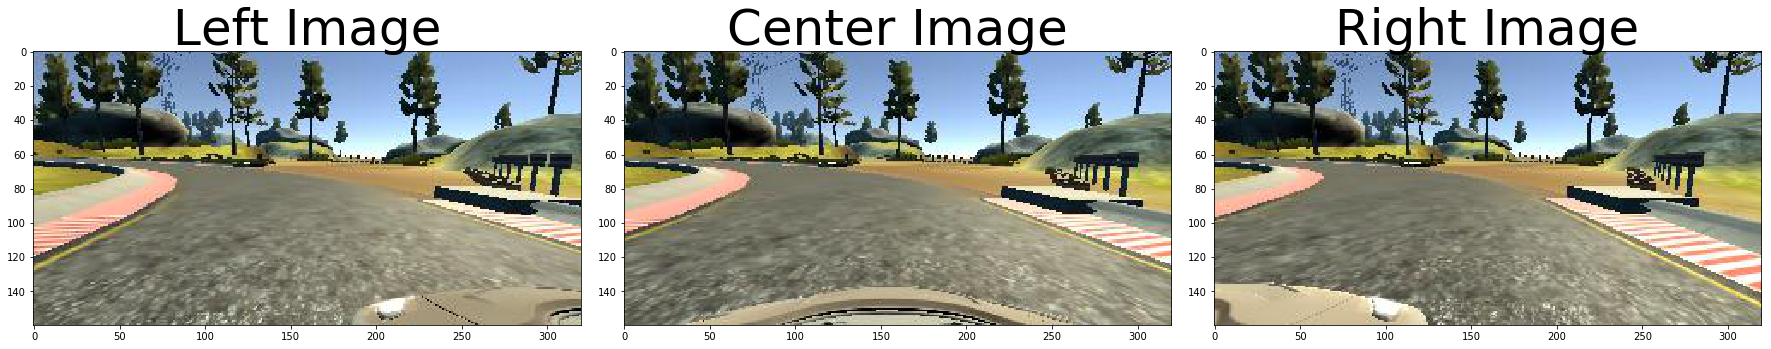

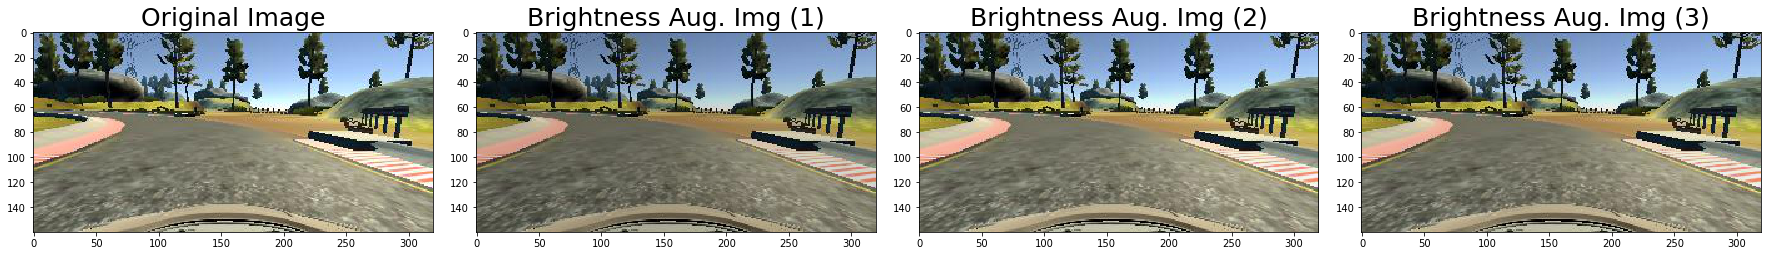

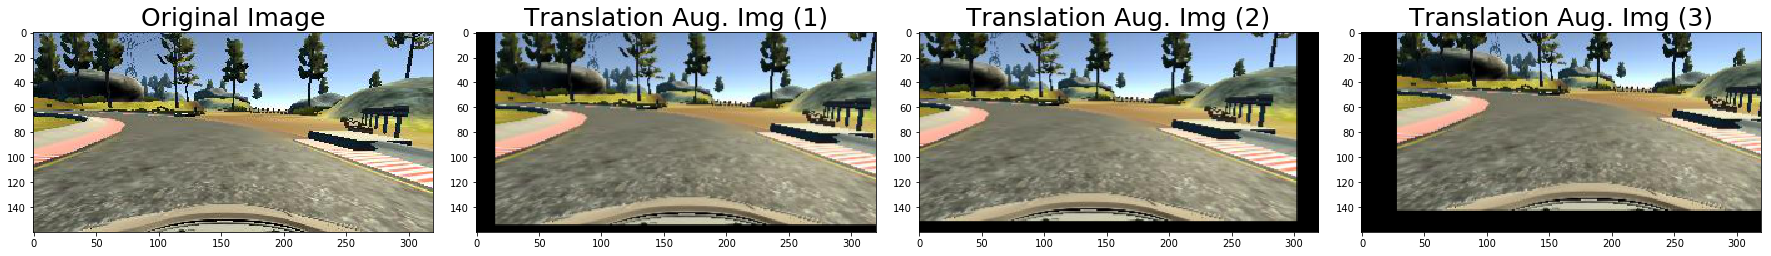

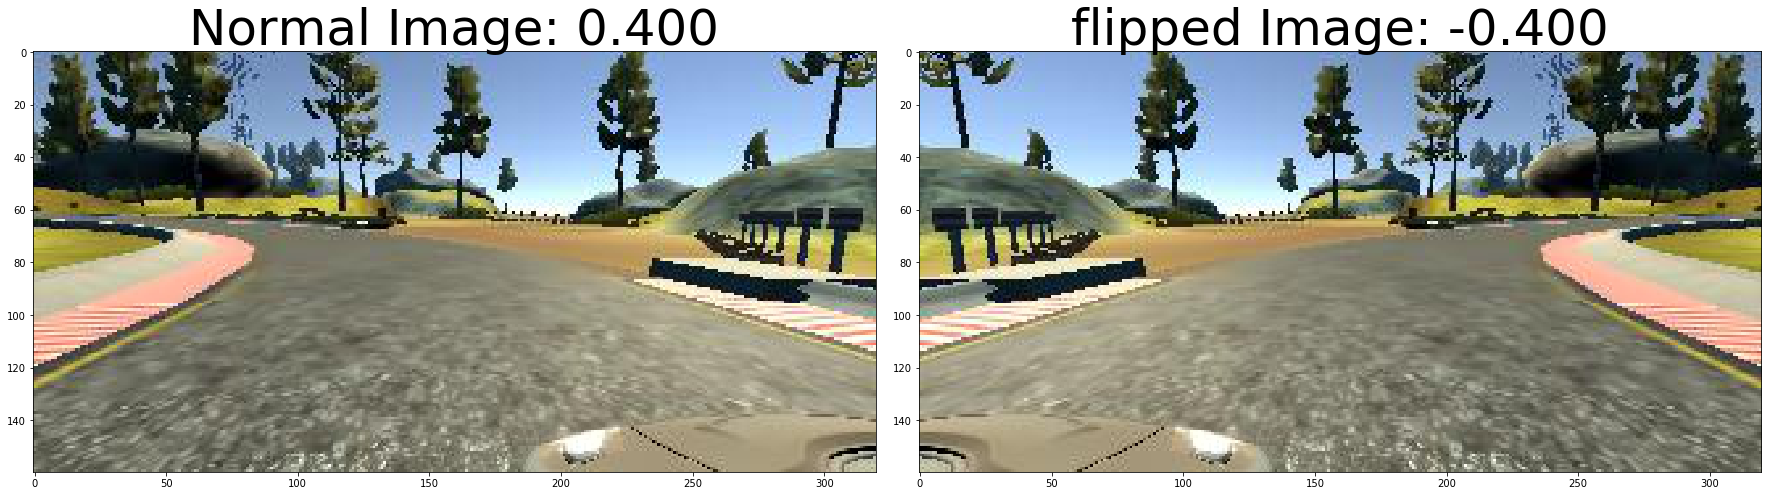

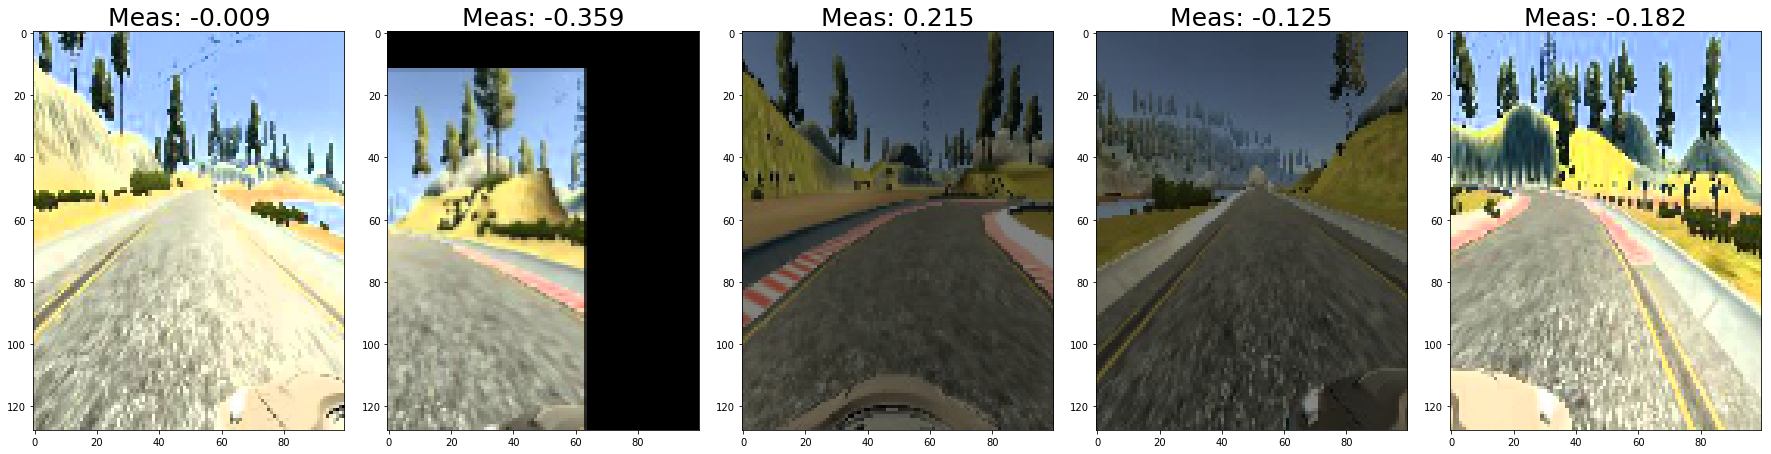

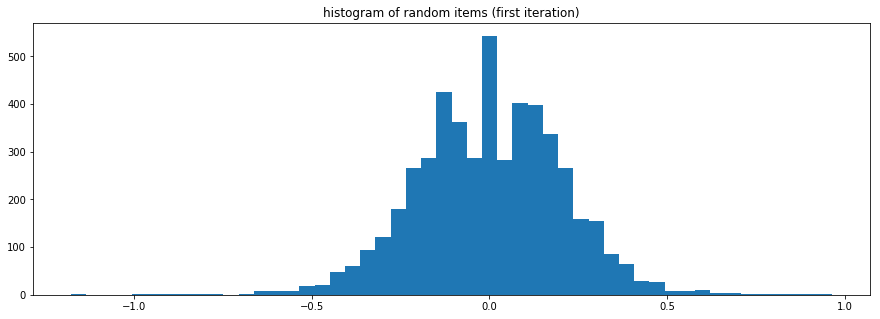

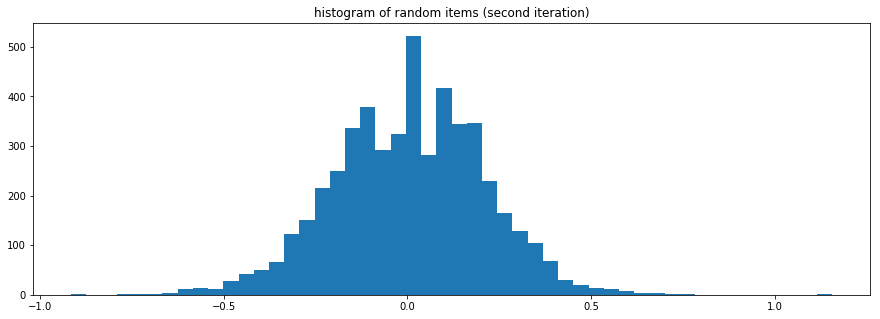

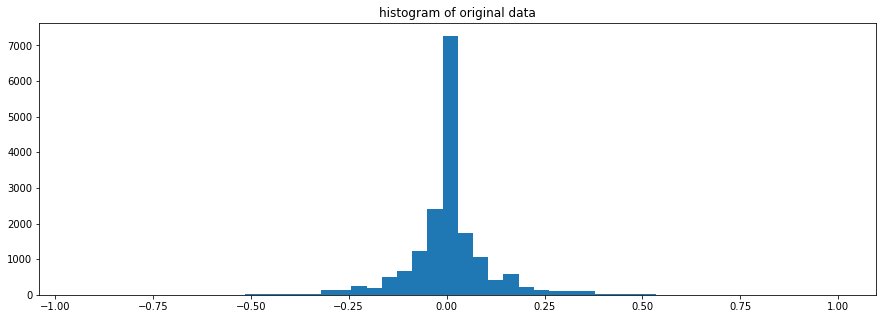

In [23]:
# CELL-07
# Manual Testing
csv_lines = read_dataset_lines(datasets)
test_line = csv_lines[2]

# display some data
display_csv_line(test_line)
# Now flip the left one
to_flip = load_image(test_line[1])
flipped_image, flipped_steering = flip_image(to_flip,0.4)

# Test some brightness augmentations
augment_test_base_image = load_image(test_line[0])
brightness_augmented_img1 = augment_brightness_camera_images(augment_test_base_image)
brightness_augmented_img2 = augment_brightness_camera_images(augment_test_base_image)
brightness_augmented_img3 = augment_brightness_camera_images(augment_test_base_image)
# and display the results
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(augment_test_base_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(brightness_augmented_img1)
ax2.set_title('Brightness Aug. Img (1)', fontsize=25)
ax3.imshow(brightness_augmented_img2)
ax3.set_title('Brightness Aug. Img (2)', fontsize=25)
ax4.imshow(brightness_augmented_img3)
ax4.set_title('Brightness Aug. Img (3)', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Test the translation augmentation
translate_test_base_image = load_image(test_line[0])
translate_augmented_img1, ang1 = trans_image(augment_test_base_image, float(test_line[3]), 75)
translate_augmented_img2, ang2 = trans_image(augment_test_base_image, float(test_line[3]), 75)
translate_augmented_img3, ang3 = trans_image(augment_test_base_image, float(test_line[3]), 75)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(translate_test_base_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(translate_augmented_img1)
ax2.set_title('Translation Aug. Img (1)', fontsize=25)
ax3.imshow(translate_augmented_img2)
ax3.set_title('Translation Aug. Img (2)', fontsize=25)
ax4.imshow(translate_augmented_img3)
ax4.set_title('Translation Aug. Img (3)', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


# And display
#print('Normal steering: ', 0.4);
#print('Flipped steering: ', flipped_steering);
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(to_flip)
ax1.set_title('Normal Image: {0:.3f}'.format(0.4), fontsize=50)
ax2.imshow(flipped_image)
ax2.set_title('flipped Image: {0:.3f}'.format(flipped_steering), fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Test the data generator
test_generator = data_generator(csv_lines, 5)
generator_images, generator_measurements = next(test_generator)
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
f.tight_layout()
ax1.imshow(generator_images[0])
ax1.set_title('Meas: {0:.3f}'.format(generator_measurements[0]), fontsize=25)
ax2.imshow(generator_images[1])
ax2.set_title('Meas: {0:.3f}'.format(generator_measurements[1]), fontsize=25)
ax3.imshow(generator_images[2])
ax3.set_title('Meas: {0:.3f}'.format(generator_measurements[2]), fontsize=25)
ax4.imshow(generator_images[3])
ax4.set_title('Meas: {0:.3f}'.format(generator_measurements[3]), fontsize=25)
ax5.imshow(generator_images[4])
ax5.set_title('Meas: {0:.3f}'.format(generator_measurements[4]), fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#print('Measure: ', next(test_generator))
#for :
#    print('test')

if (1==1):
    # predict some random measurements to
    test_generator = data_generator(csv_lines, 5000)
    _, lots_of_measurements = next(test_generator)
    plt.figure(figsize=(15,5))
    plt.title('histogram of random items (first iteration)')
    plt.hist(lots_of_measurements, bins = 50)
    
    # predict some random measurements another time
    _, lots_of_measurements = next(test_generator)
    plt.figure(figsize=(15,5))
    plt.title('histogram of random items (second iteration)')
    plt.hist(lots_of_measurements, bins = 50)

    # Show the histogram of the original data
    original_steerings = []
    for csv_line in csv_lines:
        original_steerings.append(float(csv_line[3]))
    plt.figure(figsize=(15,5))
    plt.title('histogram of original data')
    plt.hist(np.array(original_steerings), bins = 50)


In [ ]:
# CELL-08
# Full Test
# And perform the flow
csv_lines = read_dataset_lines(datasets)
# display some data
display_csv_line(csv_lines[2])

# Create the NVidia model
#model = createNvidiaModel(drop_rate=0.6)

# fitting parameters
# FULL
batch_size=400
samples_per_epoch=40000
validation_samples=8000
training_set_length=0.85
# MEDIUM
#batch_size=350
#samples_per_epoch=3500
#validation_samples=700
#training_set_length=0.85
# TEST
#batch_size=50
#samples_per_epoch=200
#validation_samples=100
#training_set_length=0.85

# split the csv lines in training and validation data
np.random.shuffle(csv_lines)
total_num_samples=len(csv_lines)
num_training_samples=int(total_num_samples*training_set_length)
csv_lines_training=csv_lines[:num_training_samples]
csv_lines_validation=csv_lines[num_training_samples:]
print('Number of CSV lines read: ', len(csv_lines))
print(' * Number of training samples: ', len(csv_lines_training))
print(' * Number of validation samples: ', len(csv_lines_validation))


#model_generator = find_optimal_model('test000001')

#### FIND the optimal one-one model, and train it
#model_generator = find_optimal_model_oneConv_oneDense("oneconv_onedense_001")
#model_generator = create_single_model_generator(
#    'best01_one-one_aug',
#    (model_image_height,model_image_width,3),
#    [[64, 7, 'elu', 'avg', 7]],
#    [[20, 'elu', 0.6]]
#)

#### FIND the optimal two-two model, and train it
#model_generator = find_optimal_model_twoConv_twoDense("twoconv_twodense_001")
#model_generator = create_single_model_generator(
#    'best01_two-two_aug',
#    (model_image_height,model_image_width,3),
#    [[8, 2, 'elu', 'avg', 2], [8, 3, 'elu', 'avg', 7]],
#    [[1000, 'elu', 0.6], [100, 'elu', 0.6]]
#)

# manual test
model_generator = create_single_model_generator(
    'best01_manual_aug',
    (model_image_height,model_image_width,3),
    [[16, 3, 'elu', 'avg', 2], [32, 3, 'elu', 'avg', 2], [64, 3, 'elu', 'avg', 2]],
    [[500, 'elu', 0.8], [100, 'elu', 0.8], [20, 'elu', 0.8]]
)

while True:
    print('****************************** STARTING NEW MODEL ******************************')
    model_name, model = next(model_generator)
    print('Training model: ', model_name)
    
    model.summary()
    model.compile(loss='mse', optimizer='adam')    
    
    # and fit the model
    model.fit_generator(
        generator=data_generator(csv_lines_training, batch_size),
        samples_per_epoch=samples_per_epoch,
        nb_epoch=150,
        callbacks=createCallbacks(model_name),
        validation_data=validation_data_generator(csv_lines_validation, batch_size),
        nb_val_samples=validation_samples
    )